In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import json
import requests
from datetime import datetime
from pprint import pprint

# Display all columns of a pandas dataframe
# pd.set_option('display.max_columns', 0)

%matplotlib inline

In [2]:
toronto_all_business_df = pd.read_csv('yelp_dataset/toronto_all_business.csv')
toronto_restaurant_business_df = pd.read_csv('yelp_dataset/toronto_restaurant_business.csv')
toronto_japanese_business_df = pd.read_csv('yelp_dataset/toronto_japanese_business.csv')

## I. Competitor Discovery

_The client of our project has been selected based both on the __number of stars (rating)__ and also **on the total number of reviews**_. 

We assume that the total number of reviews gives a strong indication of the popularity of the business, and we have selected a restaurant business with high number of ratings, since we are interested in having enough reviews to perform a comprehensive text analysis review upon the client. 

Moreover, we want to select a business with an average rating of 4.0/5.0, since we are interested in advising a client on potential ways to inprove its outreach and services into the targeted market. A business with large amount of reviews and ratings of 4.5 or 5.0 stars are highly difficult to achieve improvement with, since their ranking is already quite high, where improvments are normally found in small details, and perhaps small issues or negative reviews, even with such high overall ratings, are due to the law of large numbers and the vast preferences of customers.

__Our client is: Kinka Izakaya Original, a Japanese izakaya restaurant/bar in Toronto.__

The client is a Japanese izakaya restaurant which focuses on an evening schedule and cuisine in order to attract customers. The term "izakaya" comes from a Japanese concept of a traditional tavern with lively, cheerful atmosphere. An izakaya is well-suited both for after-work corporate small drinking events and also for family dinners. The atmosphere in most izakayas is family-friendly, with a strong emphasis on having a good time with the people around you, whether it be family members or good friends. That is why most izakayas also offer small food plates with traditional food, and servings are considered as important as the drinks themselves. This is much in contrast to bars and night restaurants, where the atmosphere is heavily focused on drinking, and is not a family-friendly environment. Therefore, our client distinguishes itself from some other evening restaurant through the thematic and the concept upon which the restaurant is centered.

In [3]:
client_row = (toronto_japanese_business_df[toronto_japanese_business_df.name == "KINKA IZAKAYA ORIGINAL"]).iloc[0]

In [4]:
# Let us print the categories of restaurant that the client is involved in:
print(client_row.categories)

category_list_client = client_row.categories.split(', ')

Restaurants, Tapas/Small Plates, Japanese, Bars, Pubs, Tapas Bars, Nightlife


### 1. Direct competitors with very similar business categories:

It is very important to know your own competition, and some of the most relevant examples of competitors are restaurants with similar or identical cuisine specific as our client has. These restaurants serve as direct competitors, no matter their size or location, since they attack the same customer market as our client does. 

We will find these competitors by looking at the number of common categories of business. Our client has 7 of them, and we will consider that if another business tackles at least 5 out of 7 of these same categories, they become our client's competitors. 

To ease our understanding of how close a business is competing with our client in terms of actual cuisine, we have considered 3 levels of direct competition:

* ___1st level competitors: businesses which tackle completely the same kind of customers (7/7 client categories match)___
* ___2nd level competitors: businesses which are very similar to our client's (6/7 client categories matched)___
* ___3rd level competitors: businesses which attack a large part of our client's customer market (5/7 client categories matched)___

In [5]:
competitor_common_categories_df = pd.DataFrame(columns = ['index', 'nr_common_categories', 'list_common_categories'])

# This for-loop iterates through all the list-format categories of every business in Toronot
for index, row in toronto_all_business_df.apply(lambda row: row.categories.split(', '), axis = 1).iteritems():

    # If the intersection between the client categories and the other business' categories is constituded of at least 1 category, then:
    if (len(set(row) & set(category_list_client)) > 0):
        
        # then append its dataframe index, the number of categories in common with the client and also their actual values to a new dataframe
        competitor_common_categories_df = competitor_common_categories_df.append({
                                               'index': index, 
                                               'nr_common_categories': len(set(row) & set(category_list_client)), 
                                               'list_common_categories': list(set(row) & set(category_list_client))
                                               }, ignore_index = True)

In [6]:
# Sort the values in the dataframe descendingly, by the number of common categories

competitor_common_categories_df = competitor_common_categories_df.sort_values(by = 'nr_common_categories', ascending = False)

In [7]:
# Show how many competitors have at least 5 out 7 common categories with our client business:

competitor_common_categories_df[competitor_common_categories_df.nr_common_categories >= 5] \
    .groupby('nr_common_categories') \
    .count() \
    .sort_index(ascending = False)[['index']] \
    .rename(columns = {'index': 'nr_of_businesses'})

,nr_of_businesses
nr_common_categories,
7,4
6,2
5,32


There are **38 main direct competitors of *Kinka Izakaya Original***, out of which __4__ are offering _exactly_ the same field of cuisine as our client (1st level: ___7/7 categories matched___), __2__ of them are almost identical in terms of business orientation (2nd level: ___6/7 categories matched___), and __32__ other restaurants are directly competing with a client by having a highly-overlapping set of business categories (3rd level: ___5/7 categories matched___)

In [8]:
competitor_common_categories_df

,index,nr_common_categories,list_common_categories
8489,18485,7,"[Pubs, Restaurants, Nightlife, Japanese, Tapas..."
8198,17836,7,"[Pubs, Restaurants, Nightlife, Japanese, Tapas..."
5371,11730,7,"[Pubs, Restaurants, Nightlife, Japanese, Tapas..."
491,1081,7,"[Pubs, Restaurants, Nightlife, Japanese, Tapas..."
1060,2353,6,"[Restaurants, Nightlife, Japanese, Tapas/Small..."
...,...,...,...
3518,7610,1,[Restaurants]
3517,7608,1,[Restaurants]
3516,7606,1,[Restaurants]
3515,7603,1,[Restaurants]


Here, we will separate the businesses according to the 3 different levels of direct competition mentioned above, depending on how close their target market is compared to the client:

In [9]:
competitor_direct_1st_level = pd.DataFrame()
competitor_direct_2nd_level = pd.DataFrame()
competitor_direct_3rd_level = pd.DataFrame()

for index in competitor_common_categories_df[competitor_common_categories_df.nr_common_categories == 7]['index']:
    competitor_direct_1st_level = competitor_direct_1st_level.append(toronto_all_business_df[toronto_all_business_df.index == index])
    
for index in competitor_common_categories_df[competitor_common_categories_df.nr_common_categories == 6]['index']:
    competitor_direct_2nd_level = competitor_direct_2nd_level.append(toronto_all_business_df[toronto_all_business_df.index == index])
    
for index in competitor_common_categories_df[competitor_common_categories_df.nr_common_categories == 5]['index']:
    competitor_direct_3rd_level = competitor_direct_3rd_level.append(toronto_all_business_df[toronto_all_business_df.index == index])

In [10]:
competitor_direct_1st_level

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
18485,CN5nuUQod0f8g3oh99qq0w,KINKA IZAKAYA ANNEX,559 Bloor St W,Toronto,ON,M5S 1Y6,43.665157,-79.410658,4.0,461,1,"{""HasTV"": ""False"", ""BikeParking"": ""True"", ""Goo...","Tapas/Small Plates, Tapas Bars, Japanese, Loca...","{""Monday"": ""17:00-0:00"", ""Tuesday"": ""17:00-0:0..."
17836,RtUvSWO_UZ8V3Wpj0n077w,KINKA IZAKAYA ORIGINAL,398 Church St,Toronto,ON,M5B 2A2,43.660430,-79.378927,4.0,1592,1,"{""RestaurantsAttire"": ""casual"", ""BusinessParki...","Restaurants, Tapas/Small Plates, Japanese, Bar...","{""Monday"": ""17:00-0:00"", ""Tuesday"": ""17:00-0:0..."
11730,igo--IP_NBWIO_yGtBJ0Eg,Ogadang,41 Spring Garden Avenue,Toronto,ON,M2N 5N6,43.764552,-79.410009,4.0,18,1,"{""Ambience"": {""touristy"": ""False"", ""hipster"": ...","Restaurants, Japanese, Pubs, Tapas/Small Plate...","{""Tuesday"": ""17:30-2:30"", ""Wednesday"": ""17:30-..."
1081,CfxVkwEJk1NAqgqMSesLzA,KINKA IZAKAYA NORTH YORK,"4775 Yonge Street, Unit 114",Toronto,ON,M2N 5M5,43.760303,-79.409798,3.5,375,1,"{""WiFi"": ""no"", ""CoatCheck"": ""False"", ""OutdoorS...","Japanese, Restaurants, Tapas/Small Plates, Pub...","{""Monday"": ""17:00-0:00"", ""Tuesday"": ""17:00-0:0..."


At the first level of direct competition, we can see that the Kinka Izakaya Original restaurant is competing with its other two smaller branches __Kinka Izakaya Annex__ & __Kinka Izakaya North York__, all of which are in Toronto. Moreover, another sub-branch of the business is a second level competitor. Since they are not competing restaurant, but rather different branches, they should be analyzed separately and will thus be put into a separate dataset:

In [11]:
kinka_all_branches_df = toronto_all_business_df[toronto_all_business_df.name.str.contains('KINKA')]

competitor_direct_1st_level = competitor_direct_1st_level[competitor_direct_1st_level['name'].isin(kinka_all_branches_df['name'].values) == False]
competitor_direct_2nd_level = competitor_direct_2nd_level[competitor_direct_2nd_level['name'].isin(kinka_all_branches_df['name'].values) == False]
competitor_direct_3rd_level = competitor_direct_3rd_level[competitor_direct_3rd_level['name'].isin(kinka_all_branches_df['name'].values) == False]

Below, we can see that only 1 other restaurant in Toronto shares exactly the same business categories as our client's izakaya business model, and also happens to have the same average rating of 4 stars, albeit from a much smaller set of reviews. These considerations make ___Ogadang___ one of our clients most direct competitors.

In [12]:
competitor_direct_1st_level

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
11730,igo--IP_NBWIO_yGtBJ0Eg,Ogadang,41 Spring Garden Avenue,Toronto,ON,M2N 5N6,43.764552,-79.410009,4.0,18,1,"{""Ambience"": {""touristy"": ""False"", ""hipster"": ...","Restaurants, Japanese, Pubs, Tapas/Small Plate...","{""Tuesday"": ""17:30-2:30"", ""Wednesday"": ""17:30-..."


Here, at the 2nd level of direct competition, we only have one other restaurant which has 6/7 common categories with our client, however this restaurant also seems to be not only much less popular, but it is out-of-business as well.

In [13]:
competitor_direct_2nd_level

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2353,996axDvF9P8zxB9MJA52Xg,Yuzu Izakaya,5582 Yonge Street,Toronto,ON,M2N,43.779041,-79.415528,4.0,26,0,"{""RestaurantsPriceRange2"": ""2"", ""GoodForKids"":...","Tapas/Small Plates, Tapas Bars, Nightlife, Res...","{""Monday"": ""17:30-2:30"", ""Tuesday"": ""17:30-2:3..."


In truth, after performing some investigations on the dataset, based on the address, the location & the types of categories that the restaurant used to approach, we have discovered that the restaurant has most likely __been rebranded__ into Hashi Izakaya, a level 3 competitor with our client. 

The change in competition level means that the restaurant has removed one of the similarities in the cuisine style that it used to approach customers with. Looking below at the comparison between the old and the new categories, we can actually see that it removed `Tapas/Small Plates`, which means that the restaurant now focuses on larger meals and full courses. Also, one more important thing to notice is that the new installment of this restaurant has added `Korean` to its list of cuisines, expanding its options and trying to reach for a broader audience. Indeed, it seems most likely that the change of name could have been done in order to create a new brand image of a mixed-Asian food restaurant, rather than just a Japanese-style one.

Still, with 5 out of 7 categories shared between our client and this restaurant, it is still considered as a strong direct competitor, as it attacks most of the same pool of customers as our client does.

In [14]:
toronto_all_business_df[toronto_all_business_df['name'].isin(['Yuzu Izakaya', 'Hashi Izakaya'])]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
2353,996axDvF9P8zxB9MJA52Xg,Yuzu Izakaya,5582 Yonge Street,Toronto,ON,M2N,43.779041,-79.415528,4.0,26,0,"{""RestaurantsPriceRange2"": ""2"", ""GoodForKids"":...","Tapas/Small Plates, Tapas Bars, Nightlife, Res...","{""Monday"": ""17:30-2:30"", ""Tuesday"": ""17:30-2:3..."
4567,KxcQs2Lkm3FJiltVWXOz_Q,Hashi Izakaya,5582 Yonge Street,Toronto,ON,M2N 5S2,43.779256,-79.415713,3.5,61,1,"{""Smoking"": ""no"", ""Ambience"": {""touristy"": ""Fa...","Korean, Tapas Bars, Japanese, Restaurants, Bar...","{""Monday"": ""17:00-2:30"", ""Tuesday"": ""17:00-2:3..."


In [15]:
toronto_all_business_df[toronto_all_business_df['name'].isin(['Yuzu Izakaya', 'Hashi Izakaya'])].categories.to_dict()

{2353: 'Tapas/Small Plates, Tapas Bars, Nightlife, Restaurants, Bars, Japanese',
 4567: 'Korean, Tapas Bars, Japanese, Restaurants, Bars, Nightlife'}

In [16]:
toronto_all_business_df[toronto_all_business_df['name'].isin(['Yuzu Izakaya', 'Hashi Izakaya'])].hours.to_dict()

{2353: '{"Monday": "17:30-2:30", "Tuesday": "17:30-2:30", "Wednesday": "17:30-2:30", "Thursday": "17:30-2:30", "Friday": "17:30-2:30", "Saturday": "17:30-2:30", "Sunday": "17:30-2:30"}',
 4567: '{"Monday": "17:00-2:30", "Tuesday": "17:00-2:30", "Wednesday": "17:00-2:30", "Thursday": "17:00-2:30", "Friday": "17:00-2:30", "Saturday": "17:00-2:30", "Sunday": "17:00-2:30"}'}

---

At the third level of competition, we see that we have 32 other businesses with similar market pool as the client:

In [17]:
print('There are', competitor_direct_3rd_level.shape[0], 'restaurants with 5/7 common categories as the client.')

There are 32 restaurants with 5/7 common categories as the client.


---

Lastly here, we will also join the set of competitors found earlier into one common dataframe, in order to have all the competitors aggregated in one structure:

In [18]:
competitor_df = competitor_direct_1st_level.append(competitor_direct_2nd_level).append(competitor_direct_3rd_level)

In [19]:
competitor_df.shape[0]

34

### 2. Restaurant competitors within the same neigbourhood/the near vicinity of the client

From a further lookup and analysis of our client on Google Maps, we can see that the client is situated in the busy Willowdale area of North Toronto, on a restaurant-packed street situated next to a commercial center. Therefore, it seems reasonable to consider the area in which our client is located for finding more potential competitors to its business, regardless of the type of restaurant involved.

We make the argument that, on a busy shopping street, people can often decide to try out new experiences and swap one restaurant for another, since there is easy proximity for the customers to choose any nearby restaurant at any moment. Therefore, we will consider competitors to be **any kind of Japanese restaurant business** situated within the same vicinity as our client.

___Here, we define vicinity loosely based on the size of the neighbourhood in which the client is located. Since Willowdale is approximately 3 kilometers in radius (6 kilometers in diameters from one side to the other), we will consider any restaurant within 3 kilometers of the exact location of Kinka Izakaya to be a competitor.___ 

This will be measured using the Vincenty ellipsoidal distance between two sets of latitude/longitude coordinate points.

In [20]:
def compute_proximity_km(row1, row2):
    # Let us create a coordinate tuple for the client
    coord_tuple1 = (row1.latitude, row1.longitude)
    
    # We create a coordinate tuple for the business
    coord_tuple2 = (row2.latitude, row2.longitude)
    
    return geo_distance.distance(coord_tuple1, coord_tuple2).kilometers

In [21]:
import geopy.distance as geo_distance

competitor_proximity_1km_df = pd.DataFrame(columns = competitor_df.columns)
competitor_proximity_2km_df = pd.DataFrame(columns = competitor_df.columns)
competitor_proximity_3km_df = pd.DataFrame(columns = competitor_df.columns)


for _, business_row in toronto_japanese_business_df.iterrows():
    
    # Here, the distance in km between the business and the client is computed
    distance_to_client = compute_proximity_km(client_row, business_row)
    
    # If the computed distance is < 1km, then add it to a proximity dataframe
    if (distance_to_client <= 1):
        competitor_proximity_1km_df = competitor_proximity_1km_df.append(business_row)
        
    # Or if the computed distance is between 1 and 2 km, then add it to a proximity dataframe
    elif(distance_to_client > 1 and distance_to_client <= 2):
        competitor_proximity_2km_df = competitor_proximity_2km_df.append(business_row)
        
    # Or if the computed distance is between 2 and 3 km, then add it to a proximity dataframe
    elif(distance_to_client > 2 and distance_to_client <= 3):
        competitor_proximity_3km_df = competitor_proximity_3km_df.append(business_row)

In [22]:
competitor_proximity_1km_df = competitor_proximity_1km_df[competitor_proximity_1km_df['name'].isin(kinka_all_branches_df['name'].values) == False]
competitor_proximity_2km_df = competitor_proximity_2km_df[competitor_proximity_2km_df['name'].isin(kinka_all_branches_df['name'].values) == False]
competitor_proximity_3km_df = competitor_proximity_3km_df[competitor_proximity_3km_df['name'].isin(kinka_all_branches_df['name'].values) == False]

Finally, let's also, separately, append these competitors into the joint `competitor_df` and remove potential duplicates, for future use in predictive modelling.

In [23]:
print('The number of proximity competitors located within 1km is:', competitor_proximity_1km_df.shape[0])
print('The number of proximity competitors located between 1km and 2km is:',competitor_proximity_2km_df.shape[0])
print('The number of proximity competitors located between 2km and 3km is:',competitor_proximity_3km_df.shape[0])

The number of proximity competitors located within 1km is: 90
The number of proximity competitors located between 1km and 2km is: 146
The number of proximity competitors located between 2km and 3km is: 68


In [24]:
competitor_df = competitor_df.append(competitor_proximity_1km_df).append(competitor_proximity_2km_df).append(competitor_proximity_3km_df)
competitor_df = competitor_df[competitor_df.duplicated() == False]

In [25]:
competitor_df.shape[0]

332

### 3. Restaurant competitors with similar overall popularity as our client

Popularity is overall a difficult term to define, however it is essential to understand that a large-scale, business-class restaurant and a family-owned small-scale restaurant do not compete on the same terms, even if they tackle a similar customer market.

Therefore, for this analysis, we will consider popularity to be a metric that is measured by __the product between the overall rating of the business and the number of total reviews given to the business (i.e. $nr_{reviews} \cdot rating$)__. Since both of these variables indicate a positive aspect as they increase ascendingly, computing such a product will tell us that the higher this value is, the more is the business well-regarded across a wider variety of customers. The number of reviews alone is not enough, because perhaps a restaurant is well-known for its negative aspects or people have a strong opinion about it; the overall rating alone is also not enough, because this can be easily influenced statistically by the law of large numbers. Therefore, it is much easier to get a high rating when there are only very few ratings, but that is not conclusive. However, if there is a high score given by an equivalently high number of population, then that rating is rather stable and indicates good quality of the business.

In [26]:
def compute_popularity_score(row):
    return row.review_count * row.stars

In [27]:
compute_popularity_score(client_row)

6368.0

We can very clearly see that our client has an extremely high popularity score, computed according to the formula described above. 

In [28]:
i = 0 # This is the number of businesses (of any kind) in Toronto with higher popularity than our client

for _, business_row in toronto_all_business_df.iterrows():
    if (compute_popularity_score(business_row) > compute_popularity_score(client_row)):
        i += 1
        print(business_row)
        print()
        print(i)

business_id                                r_BrIgzYcwo1NAuG9dLbpg
name                                    Pai Northern Thai Kitchen
address                                          18 Duncan Street
city                                                      Toronto
state                                                          ON
postal_code                                               M5H 3G8
latitude                                                  43.6479
longitude                                                -79.3887
stars                                                         4.5
review_count                                                 2758
is_open                                                         1
attributes      {"RestaurantsTableService": "True", "BikeParki...
categories      Restaurants, Thai, Specialty Food, Food, Ethni...
hours           {"Monday": "11:30-22:00", "Tuesday": "11:30-22...
Name: 6288, dtype: object

1


Actually, in the whole city of Toronto, our client is the most popular out of all Japanese restaurants, and is 2nd in popularity across all businesses. The only single business which is more popular than our client is _Pai Northern Thai Kitchen_, which is a restaurant with Thai cuisine.

To see how large is the popularity of our client compared to the other Japanese restaurants, let us look at the average popularity score across Japanese restaurants in Toronto:

In [29]:
np.average(
    toronto_japanese_business_df
    .apply(lambda business_row: compute_popularity_score(business_row), 
           axis = 1)
)

303.1756097560976

The average is ~300, and our client's score is ~6300, which is __21 times higher__ than the average. Clearly, at the time of the collection of dataset, the client was achieving very good scores from a large amount of population, however perhaps there is still something to learn from other Japanese restaurants with slightly lower popularity.

Since the scoring average is 300, we will consider any Japanese restaurant __with a popularity score of over 1000__ to be a popularity competitor with our client, since this means that, on average, the restaurant must have had e.g. more than 250 reviews of 4.0 stars, or an equivalent number, in order to achieve this treshhold. The number 1000 was selected since most of the Japanese restaurant businesses in Toronto are smaller-scale, family restaurants (according to the score calculation). 

In [30]:
competitor_popularity_df = pd.DataFrame(columns = competitor_df.columns)


for _, business_row in toronto_japanese_business_df.iterrows():
    
    # If the popularity score is higher than 1000, then add that business as a competitor
    if (compute_popularity_score(business_row) > 1000):
        competitor_popularity_df = competitor_popularity_df.append(business_row)

In [31]:
competitor_popularity_df = competitor_popularity_df[competitor_popularity_df['name'].isin(kinka_all_branches_df['name'].values) == False]

In [32]:
competitor_popularity_df.shape[0]

29

Finally, let's also, separately, append these competitors into the joint `competitor_df` and remove potential duplicates, for future use in predictive modelling.

In [33]:
competitor_df = competitor_df.append(competitor_popularity_df)
competitor_df = competitor_df[competitor_df.duplicated() == False]

In [34]:
competitor_df.shape[0]

337

---

Now, we have finalized our competitor search, however, it is important to understand that not all competitors are equally important for the business, and there are some characteristics, such as tackling the same cuisine categories, which make competition fierce, while others, such as simple longer-distance proximity, which are of lesser importance (while still being important).

Therefore, it is important to be able to identify and classify competitors across the unified dataframe (`competitor_df`), in order for our analysis to be more consistent and feasible. At the same time, a classification of this sort will also help our prediction model later on to identify potential increased number of customers from adjusting opening hours.

Based on the business sense with which we have selected our competitors here, we will assign a `competitor_importance` variable, which will go from 0 to 7 in the following way:

* **7: Any direct competitors of the 1st level, with 7/7 client categories matching**
* **6: Any direct competitors of the 2nd level, with 6/7 client categories matching**
* **5: Any direct competitors of the 3rd level, with 5/7 client categories matching**
* **4: Any competitors with similar popularity score as our client (ie. > 1000)**
* **3: Any proximity competitors located within 1km radius of our client's business location**
* **2: Any proximity competitors located within a radius of between 1 and 2 km of our client's business location**
* **1: Any proximity competitors located within a radius of between 2 and 3 km of our client's business location**
* **0: Any businesses which are in neither of the competitor sections above, therefore are not direct or indirect competitors to our client**

If a competitor fits inside multiple levels, the highest level will be recorded. We have chosen not to add the levels together (for a competitor which can fit in multiple of these categories), because that will destroy the interpretability of the variable.

In [35]:
def compute_competitor_importance(row):
    importance = 0
    
    # We do not use elif constructs here, since if a competitor fits in multiple importance levels, 
    # we want to overwrite the importance to be the highest value possible
    if (row.business_id in competitor_proximity_3km_df.business_id.to_list()):
        importance = 1
    if (row.business_id in competitor_proximity_2km_df.business_id.to_list()):
        importance = 2
    if (row.business_id in competitor_proximity_1km_df.business_id.to_list()):
        importance = 3
    if (row.business_id in competitor_popularity_df.business_id.to_list()):
        importance = 4
    if (row.business_id in competitor_direct_3rd_level.business_id.to_list()):
        importance = 5
    if (row.business_id in competitor_direct_2nd_level.business_id.to_list()):
        importance = 6
    if (row.business_id in competitor_direct_1st_level.business_id.to_list()):
        importance = 7
        
    return importance

In [36]:
competitor_df['competitor_importance'] = competitor_df.apply (
                                            lambda business_row: compute_competitor_importance(business_row),
                                            axis = 1
                                        )

Let us check the distribution of the importance levels of different competitors:

In [37]:
print(competitor_df.competitor_importance.value_counts().sort_index(ascending = False))

7      1
6      1
5     32
4     28
3     79
2    134
1     62
Name: competitor_importance, dtype: int64


It seems clear now that our competitor analysis is well-distributed, since the category with most competitors is the lower-level category where other Japanese restaurants are in a close proximity to our client, and as we increase the importance level up towards 7, the number of competitors decreases rapidly. This is normal, since the higher levels indicate a more fierce and direct competition.

In [38]:
print('Out of all the %d Japanese restaurants in Toronto, our client, %s, is competing directly or indirectly with %d of them.\nThis represents %.1f%% of the total number of Japanese restaurants.' 
      % (toronto_japanese_business_df.shape[0], 
         client_row['name'], 
         competitor_df.shape[0],
         competitor_df.shape[0] / toronto_japanese_business_df.shape[0] * 100))

Out of all the 615 Japanese restaurants in Toronto, our client, KINKA IZAKAYA ORIGINAL, is competing directly or indirectly with 337 of them.
This represents 54.8% of the total number of Japanese restaurants.


## II. Sentiment Analysis & Text Analytics upon Client vs. Competitor reviews

## III. Prediction of possible customer increase by increasing opening hours

### 1. Data Modeling & Augmentation

Even though our client is distinguishing itself from many evening-open restaurants through its unique Japanese concept, the hours of its operation are placing it in a heavily competitive situation, since the vast majority of restaurants (of any kind) is open during the evening hours of 17:00 to 00:00, since that is when most people are off-work and able to enjoy their own leisure time.

In [39]:
client_row.hours

'{"Monday": "17:00-0:00", "Tuesday": "17:00-0:00", "Wednesday": "17:00-0:00", "Thursday": "17:00-0:00", "Friday": "17:00-1:00", "Saturday": "17:00-1:00", "Sunday": "17:00-0:00"}'

However, there are many restaurant businesses to choose from during those hours, which can disperse out the mass of customers across the many restaurant that are both open and in short vicinity to our client. There are many ways in which our client could change its business operation to capture more customers, and, ___as a key point, it may be insightful to look into what kind of effect would increased opening hours have upon customers influx.___

Specifically, we can see that our client opens the business operations at __17.00__, with undergoing preparations for dinner servings probably taking place starting 1-2 hours before that. The opening hours of our client must be taken into consideration with respect to a KPI suggesting that the flux of customers available per hour which is enough for breaking-even or profit-making starts at 17.00. However, we are interested in studying the customer influx from other restaurants during earlier hours of operation, and come up with a predicition of whether it is a profitable idea for our client to start the business operations earlier.

__In this business analysis, we are going to create and provide a prediction model which investgates the total proportion of customers per weekday that our client can recieve by increasing their business hours and starting their operations one hour earlier, namely, at 16:00.__

For this predictive model, we will need to make some strict assumptions related to the data available, we will need to model the data to a high degree to prepare it for ingestion into a prediction model, and finally, we will use __Deep Learning__ to perform a _regression task_ upon the customer influx. All of these steps will be detailed clearly below, as we progress.

### Before we delve into the steps necessary for proper data modelling and augmentation to achieve predictions, it is essential that we discuss the assumptions upon which the model will be built on:

* We are trying to predict a measure of customer influx between a specific time-frame (in our case, between 16:00 and 17:00). This means that, to achieve this task, we need data about previous customer influx in the restaurants of Toronto. There is no specific dataset which tackles this problem, however ___Yelp has provided us with a list of checkins which have been done through their platform.___

* These checkins are a measure of customer influx, however there are by far much fewer checkins recorded through the Yelp service than there are actual customers in a day. At the same time, the checkins span the whole timespan of the restaurant, from the opening day up until the current date. __Therefore, we will make the assumption that the total number of checkins distributed across each _weekday_ in part (e.g. Monday, Tuesday, etc.) is _directly proportional_ with the actual total number of customers that have visited the shop.__

* Therefore, it is clear that we do not have the necessary data to predict an exact number of customers that might visit the restaurant between certain hours, since this data has not been recorded. __However, using the assumption above, we can aggregate the total number of checkins per each weekday, and divide the total number of checkins between a certain hour in a certain weekday, (e.g. Monday) to the total number of checkins during such a weekday (e.g. the total number of all checkins made on a Monday).__ This will give us a proportion that indicates what percentage of customers on a weekday come between the specific hours (out of all the customers which have come on that type of weekday, at any hour).

* __In order for the above assumption to work, we assume that every weekday will always keep the same customer influx pattern, and therefore, we disregard time-series seasonality patters and trend differences.__ This is because, if the checkin data is not aggregated according to each weekday, there is not enough data to find the seasonality trends from the checkins alone, since the checkin data is very sparse, due to its nature of being a completely voluntary action within the Yelp ecosystem.

* One final consideration that we do address in our modeling is that: each restaurant may have different opening hours for each weekday. Therefore, __the customer proportion which comes during certain hours will of course be dependent on the opening hours of the restaurant. That is why we will separate and consider the checkin data for each weekday in part, and we will compute a different customer proportion depending each of the 7 weekdays, for every restaurant, in order to account for such differences.__

Therefore, once again, our model will not be able to provide an exact number of customers that would be visiting the client during increased opening hours, instead it will output the proportion of customers that would visit our client during the specified extra hour of opening time, out of an aggregated number of all the customers that visit the izakaya during such a weekday. We will then compute how many customers that would approximately represent, based on the total aggregated number of customers for each weekday in part.

First, let us define the dataset that we are working with: for the prediction deep learning model, we will need as much relevant data as possible about the customer influx across the _Japanese restaurants_ of Toronto. That is why, for this task, we will include and work with any of the Japanese restaurants that we have available in our data (not only the direct/indirect competitors described earlier in the notebook):

In [40]:
augmented_japanese_data = toronto_japanese_business_df.copy()

However, competitors will be distinguished through applying upon this Toronto data the same data modeling steps as for the competitor dataframe: an importance score, a proximity calculation and a popularity score. Japanese restaurants which have not been featured previously as competitors will be present in this dataset with an importance score of 0 (as programmed earlier as well).

#### a) Augmentation with business importance, proximity and popularity scores:

In [41]:
augmented_japanese_data['importance'] = augmented_japanese_data.apply(
                                            lambda business_row: compute_competitor_importance(business_row), axis = 1
                                        )

augmented_japanese_data['proximity'] = augmented_japanese_data.apply(
                                            lambda business_row: compute_proximity_km(business_row, client_row), axis = 1
                                       )

augmented_japanese_data['popularity'] = augmented_japanese_data.apply(
                                            lambda business_row: compute_popularity_score(business_row), axis = 1
                                        )

In [42]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,importance,proximity,popularity
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,1,"{""Caters"": ""False"", ""HasTV"": ""True"", ""Restaura...","Food, Poke, Fast Food, Sushi Bars, Restaurants...","{""Monday"": ""11:30-22:00"", ""Tuesday"": ""11:30-22...",2,1.798516,204.0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,1,"{""GoodForMeal"": {""dessert"": ""False"", ""latenigh...","Japanese, Sushi Bars, Restaurants","{""Monday"": ""17:30-23:30"", ""Thursday"": ""17:30-2...",0,3.547277,284.0


In [43]:
print('The total number of Japanese restaurants in Toronto, all of which will be used for prediction modeling, is:', augmented_japanese_data.shape[0] - 1) # excluding our client

The total number of Japanese restaurants in Toronto, all of which will be used for prediction modeling, is: 614


It is good to know the total amount of data available to us for this challenging task, and it looks like there are 614 restaurants (excluding our client) from which we can create training and testing data for our Neural Network regression model.

Our current amount of variables is rather limited, since most of the variables in the dataset are related to general business features, such as name and address, which have no predictive power and will not be introduced in the regression model.

#### b) Augmentation with nearby amenities from OpenStreetMaps API - sources of customer influx:

__Therefore, in order to increase the chances that we have relevant attributes in our dataset which can be good predictors of the proportion of customers coming between the hours of 16:00 and 17:00 for a business, we will use the power of _OpenStreetMaps_ in order to collect data about places of interest (POI) near and around the business on a radius of ~3 kilometers, a proximity which should provide clients easy access from these amenities.__

We will use __Web Data Mining__ in order to extract data from an OpenStreetMaps API regarding the total number of amenities that one can find within a radius of 3km of each restarant in our dataset. ___In total, for each restaurant, we collect data about 20 amenities which we have carefully considered to be relevant for the influx of customers, among which we have the number of universities, libraries, arts centres, cafes, bars, other restaurants (of any kind), cinemas, and more.___ Our logic behind selecting these amenities is that: e.g. libraries and cinemas are strong sources of potential customers which are anyway in the proximity and might decide to stop by.

We will use a radius of 0.011 units, which corresponds to approximatively 3.02 km as the circular area surrounding the businesses, within which we will perform our search for amenities.

In [44]:
### This is a printed example of the JSON data output from the Overpass API:

r = 0.011
# Constructing the special String query
obj = 'node["amenity" = "%s"]'%('library')

overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
                    [out:json];
                    {0}({1},{2},{3},{4});
                    out center;
                 """.format(obj, client_row.latitude - r, client_row.longitude - r, client_row.latitude + r, client_row.longitude + r)

# Use Python's RESTful API to retrieve data in json format, as it is written the query parameter
response = requests.get(overpass_url, params={'data': overpass_query})
response_json = response.json()
pprint(response_json)

{'elements': [{'id': 380027517,
               'lat': 43.6673836,
               'lon': -79.3742632,
               'tags': {'addr:city': 'Toronto',
                        'addr:housenumber': '495',
                        'addr:street': 'Sherbourne Street',
                        'amenity': 'library',
                        'internet_access': 'wlan',
                        'internet_access:fee': 'no',
                        'name': "Toronto Public Library - St. James' Town",
                        'opening_hours': 'Tu,Th 12:30-20:30; Mo,Fr '
                                         '10:00-18:00; Sa 10:00-17:00',
                        'operator': 'Toronto Public Library',
                        'phone': '+1-416-393-7744'},
               'type': 'node'},
              {'id': 380040875,
               'lat': 43.6499639,
               'lon': -79.3684534,
               'tags': {'addr:city': 'Toronto',
                        'addr:housenumber': '171',
                        'a

In [45]:
r = 0.011 # the radius is approximately 3.02 km from the circular center

def find_amenity_count(amenity_str, lat, long):
    
    # Constructing the special String query
    obj = 'node["amenity" = "%s"]'%(amenity_str)
    
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
                        [out:json];
                        {0}({1},{2},{3},{4});
                        out center;
                     """.format(obj, lat - r, long - r, lat + r, long + r)
    
    # Use Python's RESTful API to retrieve data in json format, as it is written the query parameter
    response = requests.get(overpass_url, params={'data': overpass_query})
    response_json = response.json()
    
    return len(response_json['elements'])

In [46]:
def create_amenity_count_columns(row, row_index):
    try:
        row['osm_restaurant'] = find_amenity_count('restaurant', row.latitude, row.longitude)
    except:
        row['osm_restaurant'] = 0
#     print('Row ', row_index, ', Finished 1/20 amenities')
    try:
        row['osm_bar'] = find_amenity_count('bar', row.latitude, row.longitude)
    except:
        row['osm_bar'] = 0
#     print('Row ', row_index, ', Finished 2/20 amenities')
    try:
        row['osm_cafe'] = find_amenity_count('cafe', row.latitude, row.longitude)
    except:
        row['osm_cafe'] = 0
#     print('Row ', row_index, ', Finished 3/20 amenities')
    try:
        row['osm_fast_food'] = find_amenity_count('fast_food', row.latitude, row.longitude)
    except:
        row['osm_fast_food'] = 0
#     print('Row ', row_index, ', Finished 4/20 amenities')
    try:
        row['osm_college'] = find_amenity_count('college', row.latitude, row.longitude)
    except:
        row['osm_college'] = 0
#     print('Row ', row_index, ', Finished 5/20 amenities')
    try:
        row['osm_library'] = find_amenity_count('library', row.latitude, row.longitude)
    except:
        row['osm_library'] = 0
#     print('Row ', row_index, ', Finished 6/20 amenities')
    try:
        row['osm_school'] = find_amenity_count('school', row.latitude, row.longitude)
    except:
        row['osm_school'] = 0
#     print('Row ', row_index, ', Finished 7/20 amenities')
    try:
        row['osm_university'] = find_amenity_count('university', row.latitude, row.longitude)
    except:
        row['osm_university'] = 0
#     print('Row ', row_index, ', Finished 8/20 amenities')
    try:
        row['osm_bus_station'] = find_amenity_count('bus_station', row.latitude, row.longitude)
    except:
        row['osm_bus_station'] = 0
#     print('Row ', row_index, ', Finished 9/20 amenities')
    try:
        row['osm_parking'] = find_amenity_count('parking', row.latitude, row.longitude)
    except:
        row['osm_parking'] = 0
#     print('Row ', row_index, ', Finished 10/20 amenities')
    try:
        row['osm_taxi'] = find_amenity_count('taxi', row.latitude, row.longitude)
    except:
        row['osm_taxi'] = 0
#     print('Row ', row_index, ', Finished 11/20 amenities')
    try:
        row['osm_bank'] = find_amenity_count('bank', row.latitude, row.longitude)
    except:
        row['osm_bank'] = 0
#     print('Row ', row_index, ', Finished 12/20 amenities')
    try:
        row['osm_hospital'] = find_amenity_count('hospital', row.latitude, row.longitude)
    except:
        row['osm_hospital'] = 0
#     print('Row ', row_index, ', Finished 13/20 amenities')
    try:
        row['osm_social_facility'] = find_amenity_count('social_facility', row.latitude, row.longitude)
    except:
        row['osm_social_facility'] = 0
#     print('Row ', row_index, ', Finished 14/20 amenities')
    try:
        row['osm_arts_centre'] = find_amenity_count('arts_centre', row.latitude, row.longitude)
    except:
        row['osm_arts_centre'] = 0
#     print('Row ', row_index, ', Finished 15/20 amenities')
    try:
        row['osm_cinema'] = find_amenity_count('cinema', row.latitude, row.longitude)
    except:
        row['osm_cinema'] = 0
#     print('Row ', row_index, ', Finished 16/20 amenities')
    try:
        row['osm_casino'] = find_amenity_count('casino', row.latitude, row.longitude)
    except:
        row['osm_casino'] = 0
#     print('Row ', row_index, ', Finished 17/20 amenities')
    try:
        row['osm_theatre'] = find_amenity_count('theatre', row.latitude, row.longitude)
    except:
        row['osm_theatre'] = 0
#     print('Row ', row_index, ', Finished 18/20 amenities')
    try:
        row['osm_place_of_worship'] = find_amenity_count('place_of_worship', row.latitude, row.longitude)
    except:
        row['osm_place_of_worship'] = 0
#     print('Row ', row_index, ', Finished 19/20 amenities')
    try:
        row['osm_police'] = find_amenity_count('police', row.latitude, row.longitude)
    except:
        row['osm_police'] = 0
#     print('Row ', row_index, ', Finished 20/20 amenities')
#     print()
    
    return row

The data collection script using the Overpass API has required a total collection time of ~8 hours. Therefore, in order to facilitate swift running of this script, we have executed the script once, after which we have saved the resulting dataset (together will all the augmentation performed previously) into our data folder, and we will load it from there:

In [47]:
### This data collection function takes ~8 hours to collect all the data from our API into our dataframe
# DO NOT EXECUTE AGAIN UNNECESSARILY
# augmented_japanese_data = augmented_japanese_data.apply(lambda row: create_amenity_count_columns(row, row.name), axis = 1)

# Therefore, we have saved our resulting CSV file, and we will load it here
augmented_japanese_data = pd.read_csv('yelp_dataset/augm_japanese_restaurants_osm.csv')
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,osm_taxi,osm_bank,osm_hospital,osm_social_facility,osm_arts_centre,osm_cinema,osm_casino,osm_theatre,osm_place_of_worship,osm_police
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,2,16,0,5,1,2,0,11,14,1
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,14,0,4,0,0,0,0,9,0


The data we have collected is part of the augmentation and feature engineering necessary for having higher chances at detecting patterns within the data with our predictive model later on.

#### c) Augmentation with categorization of `category` column:

Moreover, we can see that each Japanese restaurant within our dataset has a set of categories which indicate what kind of cuisine they tackle, and this is a major deciding factor for customers. Therefore, we consider it relevant to include the individual categories within the regression data model. However, since the categories are saved as a list for each row, we will create dummy/categorical columns for each unique possible cuisine category. This is especially helpful since a restaurant often has two or more categories, therefore some data patterns may arise from having them in our model. We expect that the number of customers visiting in the early evening will be influenced by the kind of cuisine and speciality that the restaurant has.

As per _source: [UCLA Stats](https://stats.idre.ucla.edu/spss/faq/coding-systems-for-categorical-variables-in-regression-analysis-2)_: "categorical variables require special attention in regression analysis because, unlike dichotomous or continuous variables, they cannot by entered into the regression equation just as they are.  Instead, they need to be recoded into a series of variables which can then be entered into the regression model.  There are a variety of coding systems that can be used when recoding categorical variables."

From here on, we will use categorical encoding for representing cuisine categories, attributes of the restaurant, and, later on, for categorizing each weekday in its own column.

Here, we create categorical variables for each unique category by first finding the set of unique categories, wrangling the names so that they fit proper column naming styles, and then updating their values in the dataset:

In [48]:
unique_category_set = set()

# Here, we iterate over the list of categories from each Japanese business row, 
# and save the unique set of categories used by our businesses
for _, row in augmented_japanese_data.iterrows():
    row_category_list = row.categories.split(', ')
    unique_category_set = (set(unique_category_set) | set(row_category_list))
    
unique_category_list = list(unique_category_set)

# Finally, we perform string wrangling to write the column names in an appropriate format
for i in range(0, len(unique_category_list)):
    unique_category_list[i] = unique_category_list[i].lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_').replace('-', '_').replace('&', 'and')

print(list(unique_category_list))

['udon', 'pan_asian', 'thai', 'beer', 'beer_bar', 'mexican', 'bubble_tea', 'caterers', 'japanese', 'flowers_and_gifts', 'modern_european', 'coffee_and_tea', 'do_it_yourself_food', 'italian', 'tea_rooms', 'food_court', 'noodles', 'donuts', 'american_new', 'education', 'vegetarian', 'wine_bars', 'street_vendors', 'buffets', 'pizza', 'izakaya', 'vegan', 'hawaiian', 'fish_and_chips', 'pubs', 'soup', 'ethnic_food', 'seafood_markets', 'cheese_shops', 'hot_pot', 'poke', 'pasta_shops', 'tapas_small_plates', 'comfort_food', 'arts_and_entertainment', 'chicken_shop', 'food', 'shopping', 'fast_food', 'cafes', 'patisserie_cake_shop', 'restaurants', 'dim_sum', 'sandwiches', 'juice_bars_and_smoothies', 'canadian_new', 'asian_fusion', 'malaysian', 'ramen', 'desserts', 'bars', 'filipino', 'international', 'salad', 'bakeries', 'food_stands', 'breakfast_and_brunch', 'barbeque', 'steakhouses', 'local_flavor', 'taiwanese', 'creperies', 'tapas_bars', 'imported_food', 'french', 'dance_clubs', 'soul_food', 'l

With the previous category set, we need to initialize all new dummy columns in the augmented dataset, which will be having value 0 for absence of the category or 1 for the presence of the category:

In [49]:
def mark_categories(row):
    row_categories = row.categories.split(', ')
    
    for category in row_categories:
        # We perform the same string wrangling upon the categories to write the column names in an appropriate format
        category = category.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_').replace('-', '_').replace('&', 'and')
        row[category] = 1
    
    return row

In [50]:
# We initialize new categorical columns inside our augmented dataframe with 0
for category in unique_category_list:
    augmented_japanese_data[category] = 0

# Using the 'mark_categories' function, we mark each row's categories with 1 where it is appropriate
augmented_japanese_data = augmented_japanese_data.apply(lambda row: mark_categories(row), axis = 1)

In [51]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,event_planning_and_services,diners,hungarian,gluten_free,burgers,public_markets,delis,arts_and_crafts,cards_and_stationery,wine_and_spirits
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,0,0,0,0,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,0,0,0,0,0,0,0,0


Now that the cuisine categories have been transformed into dummy variables, let us remove the redundant `category` variable:

In [52]:
augmented_japanese_data = augmented_japanese_data.drop(columns = 'categories')

#### d) Augmentation with categorization of `attributes` column:

The `attributes` column holds relevant information about each business in part, such as its facilities, atmosphere and properties. It may be very helpful to encode these string attributes into categorical columns, yet, some of these attributes, in turn, contain more attributes as well. 

Therefore, we need to be careful and create these columns using Python wrangling upon the attribute values:

In [53]:
# We will want to create categorical columns for each attribute value possible
attributes_column_names = set()

# Here, we iterate over every row, retrieve its attributes as a dictionary, 
# and then link the key and value of the attributes together into one column name

for entry in augmented_japanese_data.attributes.to_list():
    entry = json.loads(entry)
    
    for key, value in entry.items():
        # If the value is a dictionary (a set of more properties),
        if (isinstance(value, dict)):
            for k, v in value.items():
                attributes_column_names.add(str(key + '_' + k + '_' + v))
        # Otherwise, the value is a string
        else:
            attributes_column_names.add(str(key + '_' + value))

Once we have all the new categorical column names, let us join our augmented data with an empty dataframe, after which we initialize all these new categorical column values with 0 as a starting point.

In [54]:
# let us join our augmented data with an empty dataframe, 
# after which we initialize all these new categorical column values with 0 as a starting point

augmented_japanese_data = augmented_japanese_data.join(pd.DataFrame(columns = attributes_column_names)).replace(np.nan, 0)

In [55]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_casual_True,GoodForMeal_latenight_True,Ambience_touristy_False,GoodForMeal_brunch_False,RestaurantsReservations_True,RestaurantsDelivery_False,HappyHour_False,Ambience_classy_True,Ambience_romantic_None,BestNights_saturday_True
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,0,0,0,0,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,0,0,0,0,0,0,0,0


Now, we need to parse each row and find the attributes and values that are present for our business, and using this, we will update the corresponding columns to indicate presence of that category (i.e. updating the column value to 1):

In [56]:
# An example of how the 'attributes' feature is presented for a row
client_row.attributes

'{"RestaurantsAttire": "casual", "BusinessParking": {"garage": "False", "street": "True", "validated": "False", "lot": "False", "valet": "False"}, "OutdoorSeating": "True", "HasTV": "False", "RestaurantsDelivery": "False", "RestaurantsGoodForGroups": "True", "RestaurantsTakeOut": "True", "Alcohol": "full_bar", "GoodForKids": "False", "RestaurantsReservations": "True", "BikeParking": "True", "RestaurantsPriceRange2": "2", "Caters": "False", "Music": {"dj": "False", "background_music": "False", "no_music": "False", "jukebox": "False", "live": "False", "video": "False", "karaoke": "False"}, "WiFi": "no", "GoodForMeal": {"dessert": "False", "latenight": "False", "lunch": "False", "dinner": "True", "brunch": "False", "breakfast": "False"}, "BestNights": {"monday": "False", "tuesday": "False", "friday": "True", "wednesday": "False", "thursday": "False", "sunday": "True", "saturday": "True"}, "GoodForDancing": "False", "HappyHour": "True", "Smoking": "no", "RestaurantsTableService": "True", "

In [57]:
def update_attribute_column_values(row):
    # Load the JSON dictionary for the row attributes
    entry = json.loads(row.attributes)

    for key, value in entry.items():
        # If the value is a dictionary (a set of more properties),
        if (isinstance(value, dict)):
            for k, v in value.items():
                row[str(key + '_' + k + '_' + v)] = 1
        # Otherwise, if the value is just a string,
        else:
            row[str(key + '_' + value)] = 1
            
    # Return the updated row (with attribute category columns updated)
    return row

In [58]:
augmented_japanese_data = augmented_japanese_data.apply(lambda row: update_attribute_column_values(row), axis = 1)
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_casual_True,GoodForMeal_latenight_True,Ambience_touristy_False,GoodForMeal_brunch_False,RestaurantsReservations_True,RestaurantsDelivery_False,HappyHour_False,Ambience_classy_True,Ambience_romantic_None,BestNights_saturday_True
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,1,0,1,1,0,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,1,1,1,1,0,0,0,0


#### e) Augmentation with categorization of _importance score_:

Since the importance score is actually a categorical interpretation of the different competitor categories, we will need to encode such a variable using one-hot-encoding:

In [59]:
# Categorize the 'importance' column, and join that to our augmented dataset
augmented_japanese_data = augmented_japanese_data.join(pd.get_dummies(augmented_japanese_data.importance, prefix = 'importance_score'))

In [60]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,Ambience_romantic_None,BestNights_saturday_True,importance_score_0,importance_score_1,importance_score_2,importance_score_3,importance_score_4,importance_score_5,importance_score_6,importance_score_7
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,0,0,0,1,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,1,0,0,0,0,0,0,0


Now that the importance score has been transformed into categories, let us remove the redundant `importance` variable:

In [61]:
augmented_japanese_data = augmented_japanese_data.drop(columns = 'importance')

#### f) Augmentation with creating the proportion of customers visiting the business during specific hours (i.e. 16:00-17:00), separated per weekday

As a final step of our data augmentation, we are interesting in finding out the proportion of customers which came during the hours of 16:00 and 17:00, for each day of the week aggregated across the whole "checkins" dataset. We have chosen these specific hours as our reference point, as we are trying to find out whether our client would gain significant increased customer flow and presence if the client were to open its business one hour earlier. Since the data is separated per weekday, and since our client opens every single day at 17:00, we will answer this question by giving a prediction for each weekday independently, in order to see what days of the week does it make sense that our client might open the restaurant earlier.

First, to compute this proportion for every Japanese restaurant we have in our dataset, we need to perform an __`INNER JOIN`__ between the augmented data and the checkins for all japanese restaurants, joining by the `business_id` attribute.

In [62]:
toronto_japanese_checkins_df = pd.read_csv('yelp_dataset/toronto_japanese_checkins.csv')

augmented_japanese_data = pd.merge(augmented_japanese_data, 
                                   toronto_japanese_checkins_df, 
                                   on = 'business_id', 
                                   how = 'inner'
                                  )
augmented_japanese_data = augmented_japanese_data.rename(columns = {'date': 'checkins'})

Afterwards, we havev created a function which reads-in every restaurant row of the dataset, checks every one of their checkin times, converts that checkin to a date, and then checks to see if that checkin date is also relevant to the time-slot that we are searching for (16:00-17:00). This function will finally compute the proportion of checkins within the searched timeslot as __the number of checkins within that timeslot for a weekday divided by the total aggregated number of checkins for that weekday.__

In [63]:
def retrieve_customer_proportion_for_hour_and_day(row, hour_string):
    desired_hour = datetime.strptime(hour_string, '%H:%M')
    
    # We will represent the days of the week as the list positions from 1 to 7 (therefore, position 0 is not used)
    checkins_desired_hour_list = [0, 0, 0, 0, 0, 0, 0, 0]
    total_checkins_list = [0, 0, 0, 0, 0, 0, 0, 0]
    
#     # Create columns corresponding to the days of the week (1 being Monday, up to 7, being Sunday)
    weekday_name_list = ['', 'mon', 'tues', 'wed', 'thur', 'fri', 'sat', 'sun']
#     for i in range(1, 8):
#         row[str(i)] = 0
        
    checkin_date_list = row.checkins.split(', ')
    for date in checkin_date_list:
        date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S')
        
        # Let's increment the total number of checkins for the found weekday
        # date.isoweekday() returns the day of week in which the checkin was done, from 1 to 7
        total_checkins_list[date.isoweekday()] += 1
        
        # let us increment the checkin counter for the day of the week during which a checkin was done, 
        # if the checkin was done during the desired hour of the day
        if ((date.hour == desired_hour.hour) and (date.minute >= desired_hour.minute)):
            checkins_desired_hour_list[date.isoweekday()] += 1
            
    # Now, we have the total number of checkins per weekday, and the total number of checkins during the desired hour, per weekday
    
    # We can compute, for each day, what is the proportion of the total checkins that would happen during the desired hour, per weekday
    # This result (the proportion) will be saved in the dataframe row, with a column name corresponding to the integer of the corresponding weekday (e.g. column "1" for monday)
    
    for i in range(1, 8):
        if (total_checkins_list[i] != 0):
            row[weekday_name_list[i]] = (checkins_desired_hour_list[i] / total_checkins_list[i])
        else:
            row[weekday_name_list[i]] = 0
        
    return row

In [64]:
augmented_japanese_data = augmented_japanese_data.apply(lambda row: retrieve_customer_proportion_for_hour_and_day(row, '16:00'), axis = 1)
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,importance_score_6,importance_score_7,checkins,mon,tues,wed,thur,fri,sat,sun
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,0,"2017-05-09 22:56:13, 2017-05-09 23:12:42, 2017...",0.142857,0.076923,0.0,0.153846,0.136364,0.0,0.0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,"2017-08-12 01:41:27, 2017-08-13 23:28:40, 2017...",0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


This format is correct in terms of the calculation, however our model needs to compute one single proportion out of 1 dataset row, and here, we can see that we have all 7 proportions (for all 7 days of the week) in the same row. 

Therefore, let us apply a pivoting function which ___converts the dataset from a wide format to a long format___ by melting the weekday variables:

In [65]:
# Let us pivot the augmented data into long format, with one row for each weekday for each restaurant
augmented_japanese_data = augmented_japanese_data.melt(id_vars = augmented_japanese_data.columns[0:-7], 
                                                       value_vars = ['mon', 'tues', 'wed', 'thur', 'fri', 'sat', 'sun'], 
                                                       var_name = 'weekday', 
                                                       value_name = 'prop')

In [66]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,importance_score_1,importance_score_2,importance_score_3,importance_score_4,importance_score_5,importance_score_6,importance_score_7,checkins,weekday,prop
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,1,0,0,0,0,0,"2017-05-09 22:56:13, 2017-05-09 23:12:42, 2017...",mon,0.142857
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,0,0,0,0,0,"2017-08-12 01:41:27, 2017-08-13 23:28:40, 2017...",mon,0.000000


Much better. Now, the total number of observations has multiplied by 7, since each restaurant will have one row in the dataset for each day of the week. 

However, now the weekdays have been encoded as a separate column, with string values corresponding to the weekday name. Since this is not the right format for a variable to be included in a regression model, we will create "dummy" categorical variables representing which of the weekdays each row has data about.

In [67]:
# Let us create categorical variables for each day of the week (so that they are not considered)
augmented_japanese_data = augmented_japanese_data.join(
                              pd.get_dummies(augmented_japanese_data['weekday'])[['mon', 'tues', 'wed', 'thur', 'fri', 'sat', 'sun']]
                          )

In [68]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,checkins,weekday,prop,mon,tues,wed,thur,fri,sat,sun
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,"2017-05-09 22:56:13, 2017-05-09 23:12:42, 2017...",mon,0.142857,1,0,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,"2017-08-12 01:41:27, 2017-08-13 23:28:40, 2017...",mon,0.000000,1,0,0,0,0,0,0


Finally, let us 'clean up' and remove the old `checkins` and `weekday` variables, which we have used in the process of creating the proportion of customers:

In [69]:
augmented_japanese_data = augmented_japanese_data.drop(columns = ['checkins', 'weekday'])

In [70]:
augmented_japanese_data.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,importance_score_6,importance_score_7,prop,mon,tues,wed,thur,fri,sat,sun
0,TKKX9bllRBMzp0NYr441PQ,Mi'Hito Sushi Laboratory,285 College Street,Toronto,ON,M5T 1S2,43.657621,-79.400885,4.0,51,...,0,0,0.142857,1,0,0,0,0,0,0
1,5JW08_RL9K60Ubo8-8lyVg,Skippa,379 Harbord Street,Toronto,ON,M6G 1H8,43.658741,-79.422842,4.0,71,...,0,0,0.000000,1,0,0,0,0,0,0


#### g) Non-relevant attribute removal & correlation matrix visualization

We have now fully augmented the dataset with as many relevant new data attributes as we could think about, and it is time to create the prediction model. One of the last steps before doing that is to remove some irrelevant attributes that are kept in the dataset, such as `state` or `name`. We could have removed such attributes at any moment in the augmentation process, however we decided not to do so until now, since it was important to check, at every step of the way, that the data was augmented properly for different restaurants, and some of those attributes allowed easy visualization that different data was indeed correctly inputted to different restaurant rows. 

Let us now first separate our client's augmented data rows from the rest of the business data, and afterwards, drop the unnecessary string-type attributes:

In [71]:
client_df = augmented_japanese_data[augmented_japanese_data['name'] == client_row['name']]
model_df = augmented_japanese_data[augmented_japanese_data['name'] != client_row['name']]

In [72]:
model_df = model_df.drop(columns = ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'is_open', 'attributes', 'hours'])

# For client_df, we will also drop the proportion, since we are sure that, because the client does not have open between those hours, the proportion will be 0.0 
# (that's actually what we're trying to predict)
client_df = client_df.drop(columns = ['business_id', 'name', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude', 'is_open', 'attributes', 'hours', 'prop'])

As we can see below from the `info()` function of `pandas`, our dataset now has only __`int`__ and __`float`__ attributes, which is exactly how the data should be prepared for a Machine Learning model:

In [73]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4200 entries, 0 to 4206
Columns: 275 entries, stars to sun
dtypes: float64(4), int64(264), uint8(7)
memory usage: 8.6 MB


In [74]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 521 to 4127
Columns: 274 entries, stars to sun
dtypes: float64(3), int64(264), uint8(7)
memory usage: 14.7 KB


It's important to remember that some of the restaurants in our data do not have open during our specified time (16:00-17:00), for some days of the week. This is probably due to a wide variety of life and business factors, something which is not quantified in the dataset. Therefore, these rows will give a proportion of __0.0__, which will bias the model into thinking that the attribute collinearity may have caused a proportion of 0.0, while this is most likely not true. __This is a good example of a situation where correlation does not imply causation, and in order to not bias the model, we will only keep and consider the data rows for the restaurants and the weekdays where the restaurant actually is open (where the proportion is > 0.0).__

In [75]:
model_df = model_df[model_df.prop > 0.0]

In [76]:
print('The total number of rows for our modeling dataset is:', model_df.shape[0])

The total number of rows for our modeling dataset is: 1756


One last thing before moving on to Machine Learning: we would like to understand how do the variables in our augmented model dataset correlate with each other. Even though multicollinearity should be well-handled by Neural Networks, it would still be best if our model would have most variables be independent of each other, in hopes that at least some of them will explain the variance in the dependent variable (`prop`).

We will use a correlation heatmap using the `seaborn` visualization package. Since there are many attributes to be displayed, please zoom in to see the individual correlation pixels:

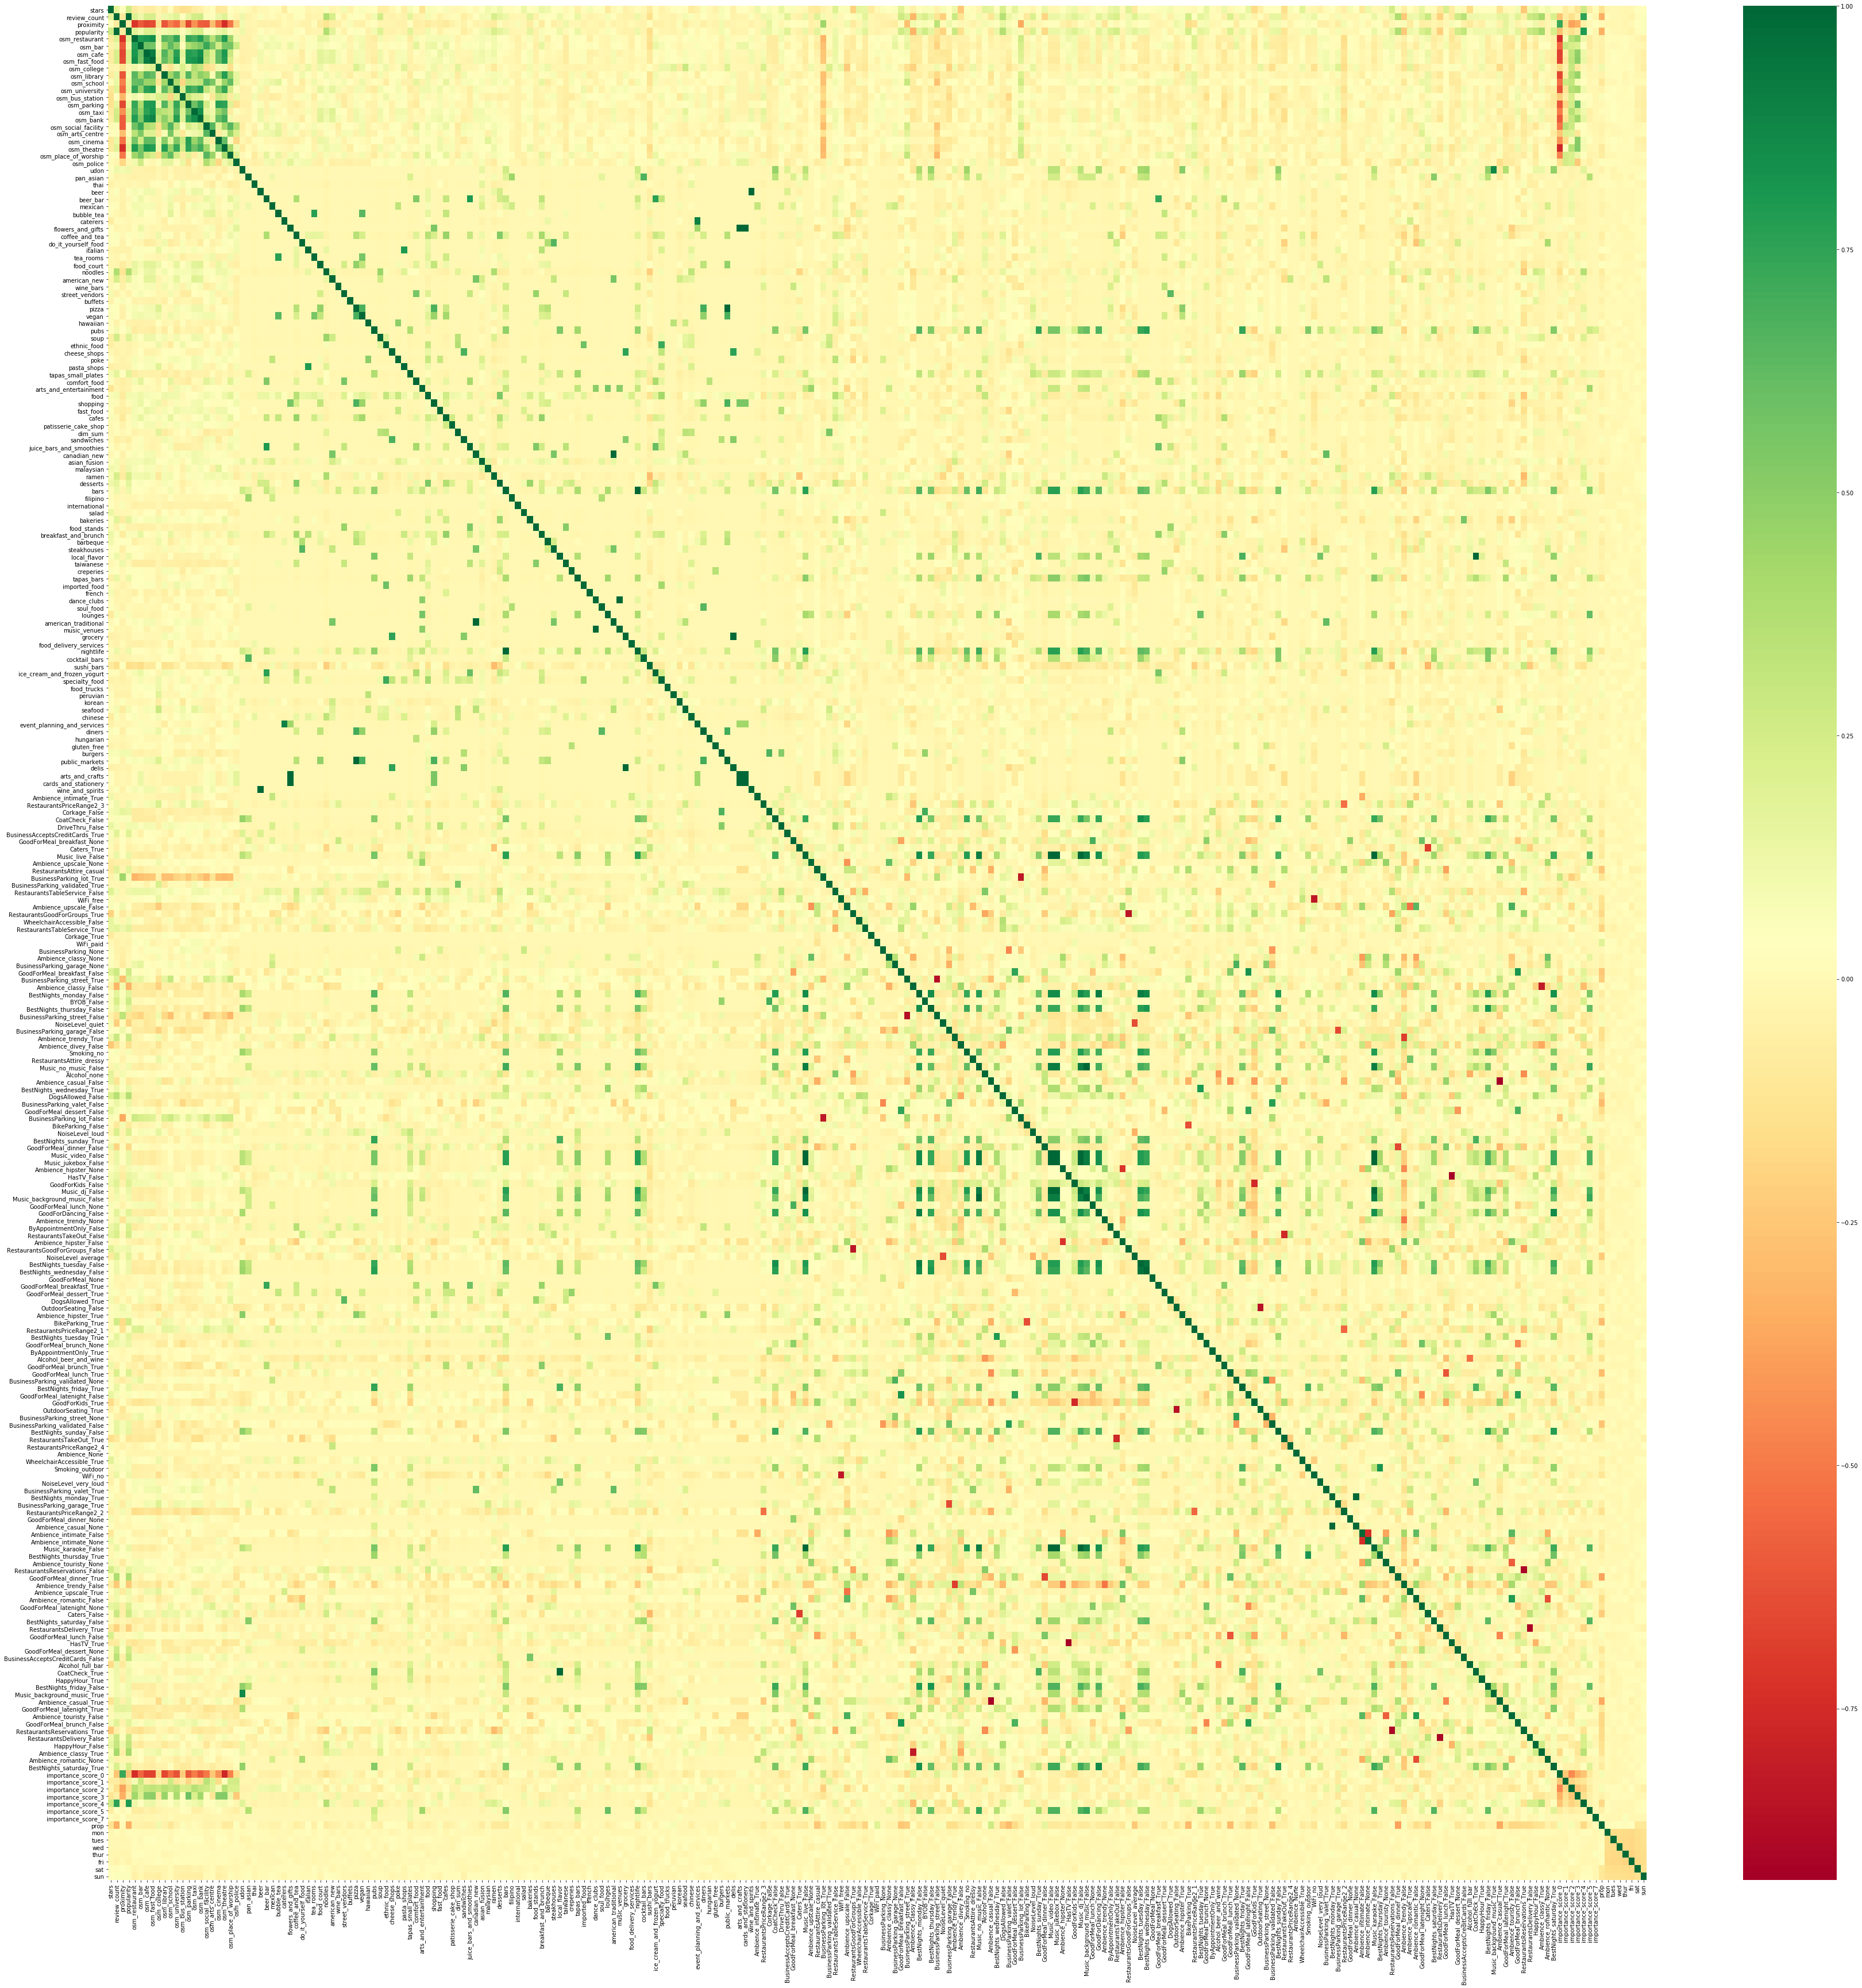

In [82]:
plt.figure(figsize = [60, 60])
sb.heatmap(model_df.corr(), cmap = 'RdYlGn');

There are 2 main observations that we can discover from the correlation heatmap above:

* It seems that our dataset is, for the most part, uncorrelated, with a few subsets of the data having moderate or high correlations due to their nature. The OpenStreetMaps-collected data is one such example of a correlated data subset, since it is reasonable that, if there is more of a type of amenity, there likely are more of multiple types of amenities, since restaurants, bars, cafes and other attractions tend to flock together. Also, some of the encoded business attributes seem to be correlated with each other, and that may be because they are subattribtes coming from the same parent attribute.

* There are some attributes for which the correlation matrix indicates vertical/horizontal __white lines__. This represents a __correlation of 0.00 for that variable with any other variable in the dataset, which is only possible if the variable in question is always having the same value for each row of the whole dataset.__ In that case, there is no variance at all for the variable, and, naturally, computing a correlation coefficient against any other variable will give its value as 0.0, since no other variables can influence its singular value. 

If a variable determines a white line within the correlation matrix, it means that it cannot explain any of the variance of the other variables, therefore it's a good idea to remove these variables from the final modeling data:

In [78]:
model_df = model_df.drop(columns = ['osm_hospital', 'osm_casino', 'donuts', 'fish_and_chips', 'izakaya', 'chicken_shop', 'restaurants', 'dive_bars', 'education', 'vegetarian', 'seafood_markets', 'kosher', 'hot_pot', 'modern_european', 'japanese', 'BYOB_True', 'Ambience_touristy_True', 'importance_score_6'])
client_df = client_df.drop(columns = ['osm_hospital', 'osm_casino', 'donuts', 'fish_and_chips', 'izakaya', 'chicken_shop', 'restaurants', 'dive_bars', 'education', 'vegetarian', 'seafood_markets', 'kosher', 'hot_pot', 'modern_european', 'japanese', 'BYOB_True', 'Ambience_touristy_True', 'importance_score_6'])

Here is the final dataset:

In [79]:
model_df.head(2)

,stars,review_count,proximity,popularity,osm_restaurant,osm_bar,osm_cafe,osm_fast_food,osm_college,osm_library,...,importance_score_5,importance_score_7,prop,mon,tues,wed,thur,fri,sat,sun
0,4.0,51,1.798516,204.0,233,0,96,147,0,0,...,0,0,0.142857,1,0,0,0,0,0,0
7,3.0,275,21.090297,825.0,2,0,1,2,0,0,...,0,0,0.046154,1,0,0,0,0,0,0


In [80]:
client_df

,stars,review_count,proximity,popularity,osm_restaurant,osm_bar,osm_cafe,osm_fast_food,osm_college,osm_library,...,importance_score_4,importance_score_5,importance_score_7,mon,tues,wed,thur,fri,sat,sun
521,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,1,0,0,0,0,0,0
1122,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,1,0,0,0,0,0
1723,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,0,1,0,0,0,0
2324,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,0,0,1,0,0,0
2925,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,0,0,0,1,0,0
3526,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,0,0,0,0,1,0
4127,4.0,1592,0.0,6368.0,292,18,170,265,0,7,...,0,0,0,0,0,0,0,0,0,1


### 2. Data Preparation for Model Ingestion

In [148]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor

from sklearn.model_selection import GridSearchCV

The first step for achieving regression predictions upon the variable _`prop`_ is to transform our dataset from a Pandas dataframe into matrixes of attributes `X` and `y`:

In [84]:
X = model_df.drop(columns = 'prop').to_numpy()
y = model_df['prop'].to_numpy().reshape((-1, 1))

X_client = client_df.to_numpy()

This is the only step needed to be done to have the model ready for ingestion. We will _not_ scale our data here, since we will make use of `sklearn`'s custom Regressors which automatically scale and inverse-scale the data at fitting, respectively at prediction times.

### 3. Prediction Model: _Linear Regression_ baseline model

Since some of our attributes have a widely different scale (e.g. `review_count`) than others (e.g. any categorical encoded variable), we draw the attention upon the problem of __feature scaling__. Scaling may be important for the correct updating of the weights in the stochastic gradient descent algorithm for Neural Networks, as well as for the coefficients/weights of the linear regression model.

For our dataset, we will use a Robust Scaler to scaler our data accordingly, since RobustScaler uses the IQR (interquartile range) of a variable, therefore working best in situations where we have skewed distributions which may contain outliers.

_It is extremely important to note the correct way of doing feature scaling: our augmented dataset is our training data, and our client data is our final testing data. Since we consider to only have the training data available to us for usage and modeling, __we will fit a feature scaler on the training data, and use the training scaler upon the testing set to scale the data__. This is very important, as we cannot include our test data in the training scaler, nor should we have a separate scaler for testing and another for training data, since they probably don't transform the data with exactly the same parameters._

For this transformation, we are using a `TransformedTargetRegressor()`, which takes in the regressor that we are fitting (_i.e. our linear regression_) and a transformer (_i.e. the RobustScaler_) which scales the data before fitting, and inverse-transforms it after predicting. For our case scenario of proportion regression, returning back the linear model output in the original scale is essential, in order to easily interpret the predicted proportion data from the linear model.

Here are the two error measures that we will use for computing the efficiency of the model. Since we are working with measurable __proportions, which take values between 0.00 and 1.00__, MAE (Mean Absolute Error) is a better loss function to interpret than the RMSE. However, we will keep both for consistency reasons.

In [116]:
def RMSE(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true)**2))

def MAE(y_pred, y_true):
    return np.mean(np.abs(y_pred - y_true))

The following setup uses __K-fold cross-validation__, with 20 folds, in order to compute a mean of RMSE and MAE errors for __two linear models__: 

* one which performs regression on the scaled data, and 
* one which computes on non-scaled data, 

in order to see whether there is any real improvement for our specific dataset whether we scale the data or not.

The `random_state` variable is set within the CV fold splitting object, in order to create reproducibility in the context of our findings.

In [147]:
# Create a cross-validation fold object which will give CV folds
KFold_CV = KFold(n_splits = 20, shuffle = True, random_state = 42)

# Create vectors to store the computed errors for each CV fold, both training and test errors
scaled_RMSE_train_values = []
scaled_MAE_train_values = []
scaled_RMSE_test_values = []
scaled_MAE_test_values = []

non_scaled_RMSE_train_values = []
non_scaled_MAE_train_values = []
non_scaled_RMSE_test_values = []
non_scaled_MAE_test_values = []

# From our full data matrix X, we create training and test data using cross-validation
for train_index, test_index in KFold_CV.split(X):
    
    # Create the training set from the CV training indexes
    X_train, y_train = X[train_index, :], y[train_index]
    
    # Create the test set from the CV test indexes
    X_test, y_test = X[test_index, :], y[test_index]
    
    # This is our linear model which works automatically upon SCALED data
    tt_lr_model = TransformedTargetRegressor(regressor = LinearRegression(fit_intercept = True, n_jobs = -1), 
                                             transformer = RobustScaler())
    
    # This is the linear regression model which fits on NON-SCALED data
    lr_model = LinearRegression(fit_intercept = True, n_jobs = -1)
    
    # We train both our models on the non-scaled data, and the TransformedTargetRegressor will automatically use its transformer to scale the data
    tt_lr_model.fit(X_train, y_train)
    lr_model.fit(X_train, y_train)
    
    non_scaled_RMSE_train_values.append(RMSE(lr_model.predict(X_train), y_train))
    non_scaled_MAE_train_values.append(MAE(lr_model.predict(X_train), y_train))
    #---------------------------------------------------------------------------#
    non_scaled_RMSE_test_values.append(RMSE(lr_model.predict(X_test), y_test))
    non_scaled_MAE_test_values.append(MAE(lr_model.predict(X_test), y_test))
    
    scaled_RMSE_train_values.append(RMSE(tt_lr_model.predict(X_train), y_train))
    scaled_MAE_train_values.append(MAE(tt_lr_model.predict(X_train), y_train))
    #--------------------------------------------------------------------------#
    scaled_RMSE_test_values.append(RMSE(tt_lr_model.predict(X_test), y_test))
    scaled_MAE_test_values.append(MAE(tt_lr_model.predict(X_test), y_test))

    
print('TRAIN SET RMSE:')
print('(Mean: Train RMSE - NON-SCALED data) for linear regression upon the japanese business dataset: ', str(np.mean(non_scaled_RMSE_train_values)))
print('(Std:  Train RMSE - NON-SCALED data) for linear regression upon the japanese business dataset: ', str(np.std(non_scaled_RMSE_train_values)))
print('(Mean: Train RMSE - SCALED data) for linear regression upon the japanese business dataset:     ', str(np.mean(scaled_RMSE_train_values)))
print('(Std:  Train RMSE - SCALED data) for linear regression upon the japanese business dataset:     ', str(np.std(scaled_RMSE_train_values)))
print()
print('TEST SET RMSE:')
print('(Mean: Test RMSE - NON-SCALED data) for  linear regression upon the japanese business dataset: ', str(np.mean(non_scaled_RMSE_test_values)))
print('(Std:  Test RMSE - NON-SCALED data) for  linear regression upon the japanese business dataset: ', str(np.std(non_scaled_RMSE_test_values)))
print('(Mean: Test RMSE - SCALED data) for  linear regression upon the japanese business dataset:     ', str(np.mean(scaled_RMSE_test_values)))
print('(Std:  Test RMSE - SCALED data) for  linear regression upon the japanese business dataset:     ', str(np.std(scaled_RMSE_test_values)))
print('----------------------------------------------------------------------------------------------------------------------')
print('TRAIN SET MAE:')
print('(Mean: Train MAE - NON-SCALED data) for linear regression upon the japanese business dataset:  ', str(np.mean(non_scaled_MAE_train_values)))
print('(Std:  Train MAE - NON-SCALED data) for linear regression upon the japanese business dataset:  ', str(np.std(non_scaled_MAE_train_values)))
print('(Mean: Train MAE - SCALED data) for linear regression upon the japanese business dataset:      ', str(np.mean(scaled_MAE_train_values)))
print('(Std:  Train MAE - SCALED data) for linear regression upon the japanese business dataset:      ', str(np.std(scaled_MAE_train_values)))
print()
print('TEST SET MAE:')
print('(Mean: Test MAE - NON-SCALED data) for linear regression upon the japanese business dataset:   ', str(np.mean(non_scaled_MAE_test_values)))
print('(Std:  Test MAE - NON-SCALED data) for linear regression upon the japanese business dataset:   ', str(np.std(non_scaled_MAE_test_values)))
print('(Mean: Test MAE - SCALED data) for linear regression upon the japanese business dataset:       ', str(np.mean(scaled_MAE_test_values)))
print('(Std:  Test MAE - SCALED data) for linear regression upon the japanese business dataset:       ', str(np.std(scaled_MAE_test_values)))

TRAIN SET RMSE:
(Mean: Train RMSE - NON-SCALED data) for linear regression upon the japanese business dataset:  0.1191567394926091
(Std:  Train RMSE - NON-SCALED data) for linear regression upon the japanese business dataset:  0.0010318036591394186
(Mean: Train RMSE - SCALED data) for linear regression upon the japanese business dataset:      0.1191567394926091
(Std:  Train RMSE - SCALED data) for linear regression upon the japanese business dataset:      0.0010318036591394203

TEST SET RMSE:
(Mean: Test RMSE - NON-SCALED data) for  linear regression upon the japanese business dataset:  0.14181555490908934
(Std:  Test RMSE - NON-SCALED data) for  linear regression upon the japanese business dataset:  0.016658607442905083
(Mean: Test RMSE - SCALED data) for  linear regression upon the japanese business dataset:      0.14181555490908954
(Std:  Test RMSE - SCALED data) for  linear regression upon the japanese business dataset:      0.016658607442905024
------------------------------------

The results from the linear model prediction seem to be reliable, because, __in both scaled & non-scaled scenarios, across 20 CV folds, the training error and testing error are very close to each other. This indicates that the model is not doing large amounts of overfitting__.

Moreover, if we look at the testing set difference in errors between scaled and non-scaled data, both RMSE and MAE coincide perfectly until the 15th decimal! <br> This shows that, using a linear model for our data, the model does not seem to take into account the features with large scale differences compared to our categorical variables (having values between 0 and 1).

__Lastly, it is important to understand that our Test set MAE average error of $\mu = $ 0.09, with a standard deviation $\sigma = $ 0.005 means that, when predicting for our client the average proportion of customers that would come between 16:00 and 17:00, such predictions will have a margin of error between ($\mu-3\sigma, \mu+3\sigma$). More specifically, the prediction that our client would receive from the linear model would be between $7.5\% - 10.5\%$ lower or higher.__ This error marging would surely decrease, given more data to be fed into the model, since reaching a low MAE from only 4000 entries is an expected challenge.

### 4. Prediction Model: _Neural Networks_ model

### 5. Model performance comparison

### 6. Final client proportion prediction & Conclusion